In [78]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Identify Fraud from Enron Email

 *Feng Li*
 
 *6/29/2016*

**Question 1**

**Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]**

### Data Exploration 

Enron Corpus is a compilation of emails generated by Enron employees and acquired after the company's collapse. The dataset this project is based on includes Enron employees' financial compensation and their email activities to and from other employees, and the label whether the person is a person of interest (POI) or not is also given, which is described as individual who is 'indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity'.

By evaluation these financial and email related features using machine learning techniques, we are trying to predict who within the company should be considered as a POI.

In [35]:
import sys
sys.path.append("../tools/")
import pickle
import matplotlib.pyplot as plt 
%pylab inline
import seaborn as sns
import pandas as pd
import numpy as np
import feature
from model import create_pipeline
from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.cross_validation import train_test_split
import sklearn.metrics
from tester import dump_classifier_and_data, test_classifier

Populating the interactive namespace from numpy and matplotlib


The data has the following characteristics:

In [4]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
  
print 'Total number of data points: %d' % len(data_dict)

poi_count = 0
for point in data_dict.keys():
    poi_count += data_dict[point]['poi']    
print 'Number of POI: %d' % poi_count  
    
all_features = data_dict['BUY RICHARD B'].keys()
print 'Features for each person:  %s' %  all_features

Total number of data points: 146
Number of POI: 18
Features for each person:  ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


These features are categorized as follows:

**financial features:**
'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'

**email features:**
'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'

**payment features:**
'salary', 'deferral_payments','bonus', 'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'total_payments'

**stock features:**
'exercised_stock_options', 'restricted_stock','restricted_stock_deferred', 'total_stock_value'

### Outlier Investigation 

To find the outliers in the financial data, I plot the salary and bonus for each point, and find a point with extremely large values, which is 'TOTAL' sum of all records. This point is removed.

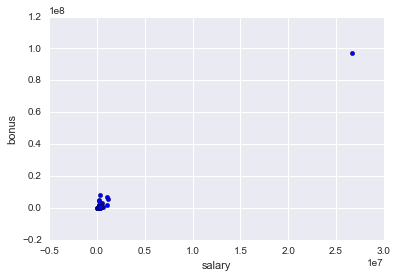

In [5]:
# check for outliers
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

salary = []
bonus = []
for i in range(len(data)):
    salary.append(data[i][0])
    bonus.append(data[i][1]) 
       
plt.scatter(salary, bonus)
plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()

In [6]:
# find the point with maxium salary
for key in data_dict.keys():
    if (data_dict[key]['salary'] == max(salary)):
        print key   

TOTAL


In [7]:
data_dict.pop('TOTAL', 0) 

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [8]:
data_dict.pop('LOCKHART EUGENE E',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

The point for person LOCKHART EUGENE E has no entries for any feature, so it's removed.

After these two points are removed, there are 144 remaining points to use for prediction.

### Feature Engineering

First let's take a look at email features. 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi' are all absolute statistics, not good enough to make comparison of the person's email activities with POIs. So I create two new features: **"fraction_from_poi_email"**, the ratio of emails from POIs to all emails received, and **"fraction_to_poi_email"**, the ratio of emails to POIs to all emails sent.

In [9]:
feature.get_faction("from_poi_to_this_person","to_messages", "fraction_from_poi_email", data_dict)
feature.get_faction("from_this_person_to_poi","from_messages", "fraction_to_poi_email", data_dict)

Then I plot the two new features, red for POI and blue for non-POI. We can see POIs have both high "fraction_from_poi_email" and "fraction_to_poi_email". And those who only have high "fraction_from_poi_email" or high "fraction_to_poi_email" tend to be non-POIs.

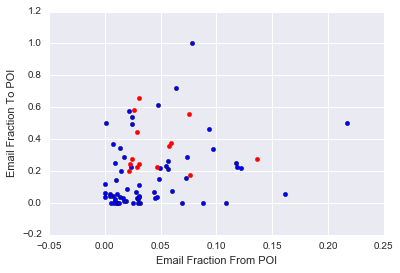

In [10]:
features = ["poi","fraction_from_poi_email", "fraction_to_poi_email"]
data = featureFormat(data_dict, features)     
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color='red')
    else:
        plt.scatter(from_poi, to_poi)

plt.xlabel("Email Fraction From POI")
plt.ylabel("Email Fraction To POI")
plt.show()

Then I create two new features to sum up the email activities and the financial compensation.

In [11]:
feature.get_total(["from_poi_to_this_person", "from_poi_to_this_person", "shared_receipt_with_poi"], "total_poi_interaction", data_dict)
feature.get_total(['total_payments', 'total_stock_value'], 'total_compensation', data_dict)

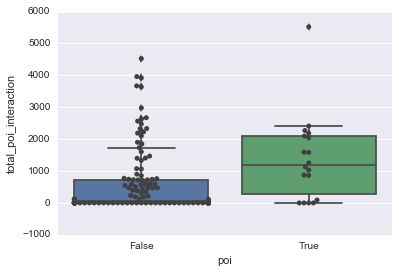

In [12]:
# create pandas Dataframe from dataset
full_df = pd.DataFrame.from_dict(data_dict, orient='index') 
ax = sns.boxplot(x="poi", y="total_poi_interaction", data=full_df)
ax = sns.swarmplot(x="poi", y="total_poi_interaction", data=full_df, color=".25")

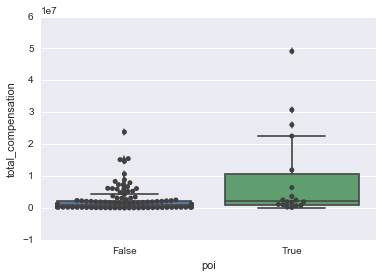

In [13]:
ax = sns.boxplot(x="poi", y="total_compensation", data=full_df)
ax = sns.swarmplot(x="poi", y="total_compensation", data=full_df, color=".25")

From both the plots, POIs have higher median and interquartile range of interaction with other POIs and total financial compensation than non-POIs.

### Missing Value Imputation

In [14]:
full_df.replace('NaN', np.nan, inplace=True)
print 'Number of NaNs for each column: \n',full_df.isnull().sum()

Number of NaNs for each column: 
to_messages                   58
deferral_payments            106
expenses                      50
fraction_to_poi_email          0
poi                            0
deferred_income               96
email_address                 33
long_term_incentive           79
restricted_stock_deferred    127
shared_receipt_with_poi       58
loan_advances                141
from_messages                 58
other                         52
director_fees                128
fraction_from_poi_email        0
bonus                         63
total_stock_value             19
from_poi_to_this_person       58
from_this_person_to_poi       58
total_compensation             0
restricted_stock              35
salary                        50
total_payments                20
exercised_stock_options       43
total_poi_interaction          0
dtype: int64


Except label 'poi' and 4 created features, each column has missing values. Since we can't find any reasonable support to make inference of these values, I decide to imputate them with 0.

And I also drop the 'email_address' column, since it won't be of any use in the statistical machine learning process.

In [15]:
# imputate missing value with 0
full_df = full_df.replace(np.nan, 0)
# remove unuseful column
df = full_df.drop('email_address', axis = 1)
# drop label column and get features dataframe
features_df = full_df.drop(['email_address', 'poi'], axis = 1).astype(float)

**Question 2**

**What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]**

### Preliminary Feature Selection

First let's take a look at the correlation of all other features with the label.

In [16]:
# correlation of columns with 'poi'
corrs = df.corr()
corrs.sort_values(by = ['poi'], ascending=False)['poi']

poi                          1.000000
exercised_stock_options      0.387553
total_stock_value            0.383382
total_compensation           0.370774
bonus                        0.359381
salary                       0.340120
fraction_to_poi_email        0.323885
long_term_incentive          0.257361
restricted_stock             0.248509
total_payments               0.242429
total_poi_interaction        0.240876
shared_receipt_with_poi      0.240876
loan_advances                0.220295
expenses                     0.205077
from_poi_to_this_person      0.190460
other                        0.169590
fraction_from_poi_email      0.148698
from_this_person_to_poi      0.129619
to_messages                  0.108730
restricted_stock_deferred   -0.021388
from_messages               -0.033982
deferral_payments           -0.039067
director_fees               -0.120936
deferred_income             -0.274762
Name: poi, dtype: float64

Then I call SelectKBest to do preliminary feature selection, using Anova F-value scoring for classification. I don't use chi2 scoring because there are many negative values in the data. I do this step out of the consideration that there are relatively too many features for such a small dataset. Here is the sorted feature score table. Since 'restricted_stock_deferred', 'from_messages', 'deferral_payments' have very low correlation with the label and low scores, I decide that it's safe to remove these three features and keep the rest for further feature selection.

In [17]:
print 'There are', sum(features_df['deferred_income'] < 0), "negative values in column 'deferred_income'."

There are 48 negative values in column 'deferred_income'.


In [18]:
# examine the importance of features
selection = SelectKBest(k='all', score_func=f_classif).fit(features_df, df['poi'])    
scores = pd.DataFrame([features_df.columns, selection.scores_]).T
scores.columns = ['Features', 'Scores']
scores = scores.sort_values(by=['Scores'], ascending=False).reset_index(drop=True)
print scores

                     Features     Scores
0     exercised_stock_options    25.0975
1           total_stock_value    24.4677
2          total_compensation    22.6325
3                       bonus      21.06
4                      salary    18.5757
5       fraction_to_poi_email    16.6417
6             deferred_income    11.5955
7         long_term_incentive    10.0725
8            restricted_stock     9.3467
9              total_payments    8.86672
10    shared_receipt_with_poi    8.74649
11      total_poi_interaction    8.74649
12              loan_advances    7.24273
13                   expenses     6.2342
14    from_poi_to_this_person    5.34494
15                      other    4.20497
16    fraction_from_poi_email    3.21076
17    from_this_person_to_poi    2.42651
18              director_fees    2.10766
19                to_messages    1.69882
20          deferral_payments   0.217059
21              from_messages   0.164164
22  restricted_stock_deferred  0.0649843


In [19]:
# use the first 20 features by SelectKBest
features_list = np.hstack((['poi'], scores['Features'][:20].tolist()))

**Question 3**

**What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]**

**Question 4**

**What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]**

### Further Feature Selection And Algorithm Tuning

To evaluate the performance of different machine learning algorithms and parameters, I use a pipeline, created by create_pipeline function in model.py, to perform multi-step operations.

The pipeline does the following steps:

    1. Standardize the features to be centered around 0 with a standard deviation of 1 by using StandardScaler
    2. Select features using SelectKBest and Anova F-value classification scoring 
    3. Reduce dimensionality using Principal Component Analysis
    4. Feed the resulting PCA components to classification algorithms.

Scaling the features is important to many machine learning algorithms, because the data are on vastly different scales ranging from large sums of money to hundreds of emails. To perform PCA, I prefer standardization over Min-Max scaling, since PCA seeks to maximize the variance of each component. 

SelectKBest and PCA dimension reduction are then run during each of the cross-validation loops. The K-best features are selected using the Anova F-value classification scoring function.

Since there are 20 features except label, I set the list of k value, the number of features allowed to select, to be **[6, 7, 8, 9, 10, 11, 12, 13]**.

After PCA dimensionality reduction, the resultant components are fed to different classification algorithms, which are generated by create_classifier_step function in model.py.

However, the results turn out not good enough at first try, and the recall scores are lower than 0.3. After I change the k value for KBestSelect, it doesn't improve much. So I comment out the PCA, and get precision and recall scores higher than 0.3.

Parameter tuning is important for machine learning algorithm, which means finding the optimal combination of cinfiguration parameters that yield best result. In this project, we're looking for the highest recall score, so I set GridSearchCV scoring as 'recall'.

In [74]:
algorithms = ['Naive_Bayes', 'Logistic_Regression', 'SVM', 'Decision_Tree', 'KNN', 'AdaBoost', 'Random_Forest']

There are 7 algorithms are evaluated: Naive Bayes, Logistic Regression, SVM, Decision Tree, KNN, AdaBoost and Random Forest. 

The following parameter lists are used by GridSearchCV to search for the optimal parameters for every algorithm.

+ **Naive Bayes** (empty)

+ **Logistic Regression**

    'C' : [10, 100, 1000, 10000, 100000] (Smaller C specifies stronger regularization)
    

+ **SVM**
    
    'kernel' : ['linear', 'rbf', 'poly']  
    
    (Linear kernal is usefull to avoid overfitting when there are not enough training data points, and polynomial and RBF are useful when the data points are not linearly separable.
    
    'C' : [10, 100, 1000, 10000, 100000]
    

+ **Decision Tree**

    'min_samples_split' : [30, 40, 50, 60]
    
    (Higher values prevent a model from learning relations which might be highly specific to the particular sample)
    

+ **KNN**

    'n_neighbors' : [4, 6, 8, 10]
    
    'weights' : ['uniform', 'distance']
    

+ **AdaBoost**

    'n_estimators' : [10, 30, 50, 70]
    
    'learning_rate' : [0.01, 0.03, 0.1, 0.3, 1, 3]
    
    
+ **Random Forest**

    'n_estimators' : [2, 5, 7, 10, 12]
    
    'max_features' : ['sqrt', 'log2']
    

**Question 5**

What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]

### Cross Validation 

Validation is the process of evaluating how a model performs on unseen data. A classic mistake can be that the model fits the training data very well with low error, but performs poorly on unseen test data, which is called overfitting. To avoid overfitting, we can perform cross validation.

In cross validation, dataset is split randomly into training and test datasets (or plus validation dataset), and the model is trained on  training data, and validated on test data.

This is used in algorithm tuning, when the algorithms run over 100 randomized stratified shuffle splits. The results(recall) are scored in each split on the test data, and the score is averaged over all 100 splits. The parameters which give the highest average recall are selected for the final model.

Here StratifiedShuffleSplit is used, because the dataset is rather skew. To do cross validation, it could turn out there are no POIs in training data or test data if we use usual train_test_split, which can make the model not well trained or precisely evaluated. With StratifiedShuffleSplit, every fold it generates will contain equal proportions of POI and non-POI.

After getting the optimum parameters for each algorithm, I iterate every algorithm on test_classifier function in tester.py to select the best algorithm. A similar cross validation method with StratifiedShuffleSplit is used.

**Question 6**

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

### Evaluation Metrics

In [63]:
# transform dataframe to dictionary
my_dataset = df.T.to_dict() 
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.5, random_state=42)
   
def run_algorithm(algorithm):    
    print 'Running', algorithm, '----------'
    clf, selected_features = create_pipeline(algorithm, features_train, labels_train, features_list)
    print 'Selected features with scores:'
    print selected_features, '\n'
    test_classifier(clf, my_dataset, features_list)

In [64]:
run_algorithm(algorithms[0]) 

Running Naive_Bayes ----------
Selected features with scores:
                  Features     Scores
0                    bonus  45.395553
1          deferred_income  22.087886
2                   salary  18.980036
3      long_term_incentive  12.080473
4           total_payments  11.801346
5  exercised_stock_options  11.783110 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=6, score_func=<function f_classif at 0x1187c2ed8>)), ('Naive_Bayes', GaussianNB())])
	Accuracy: 0.84920	Precision: 0.41853	Recall: 0.33650	F1: 0.37306	F2: 0.35023
	Total predictions: 15000	True positives:  673	False positives:  935	False negatives: 1327	True negatives: 12065



In [65]:
run_algorithm(algorithms[1])

Running Logistic_Regression ----------
Selected features with scores:
                  Features     Scores
0                    bonus  45.395553
1          deferred_income  22.087886
2                   salary  18.980036
3      long_term_incentive  12.080473
4           total_payments  11.801346
5  exercised_stock_options  11.783110 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=6, score_func=<function f_classif at 0x1187c2ed8>)), ('Logistic_Regression', LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.85893	Precision: 0.43737	Recall: 0.20250	F1: 0.27683	F2: 0.22687
	Total predictions: 15000	True positives:  405	False positives:  521	False negatives: 1595	True negatives: 12479



In [66]:
run_algorithm(algorithms[2]) 

Running SVM ----------
Selected features with scores:
                   Features     Scores
0                     bonus  45.395553
1           deferred_income  22.087886
2                    salary  18.980036
3       long_term_incentive  12.080473
4            total_payments  11.801346
5   exercised_stock_options  11.783110
6         total_stock_value  11.569330
7        total_compensation  11.464329
8     fraction_to_poi_email   9.766294
9   shared_receipt_with_poi   9.285133
10    total_poi_interaction   9.285133
11            loan_advances   8.877749
12                    other   7.168455 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=13, score_func=<function f_classif at 0x1187c2ed8>)), ('SVM', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
run_algorithm(algorithms[3]) 

Running Decision_Tree ----------
Selected features with scores:
                  Features     Scores
0                    bonus  45.395553
1          deferred_income  22.087886
2                   salary  18.980036
3      long_term_incentive  12.080473
4           total_payments  11.801346
5  exercised_stock_options  11.783110
6        total_stock_value  11.569330 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=7, score_func=<function f_classif at 0x1187c2ed8>)), ('Decision_Tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82460	Precision: 0.23103	Recall: 0.13550	F1: 0.17082	F2: 0.14772
	Total predictions: 15000	True positives:  271	False positives:  902	False negatives: 1729	T

In [68]:
run_algorithm(algorithms[4]) 

Running KNN ----------
Selected features with scores:
                  Features     Scores
0                    bonus  45.395553
1          deferred_income  22.087886
2                   salary  18.980036
3      long_term_incentive  12.080473
4           total_payments  11.801346
5  exercised_stock_options  11.783110
6        total_stock_value  11.569330
7       total_compensation  11.464329 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=8, score_func=<function f_classif at 0x1187c2ed8>)), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])
	Accuracy: 0.83607	Precision: 0.27073	Recall: 0.13550	F1: 0.18061	F2: 0.15054
	Total predictions: 15000	True positives:  271	False positives:  730	False negatives: 1729	True negatives: 12270



In [76]:
run_algorithm(algorithms[5]) 

Running Random_Forest ----------
Selected features with scores:
                  Features     Scores
0                    bonus  45.395553
1          deferred_income  22.087886
2                   salary  18.980036
3      long_term_incentive  12.080473
4           total_payments  11.801346
5  exercised_stock_options  11.783110 

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=6, score_func=<function f_classif at 0x1187c2ed8>)), ('Random_Forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', ma...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.84300	Precision: 0.35968	Recall: 0.22750	F1: 0.27871	F2: 0.24555
	Total predictions: 15000	True positives:  455	False positives:  810	False negatives: 1545	True negatives: 12190



The evaluation metrics for each algorithms are as follows.

Accuracy answers question 'what percent of the predictions are right', and it is the ratio of correct prediction. It's not very useful for this project, because there are too many non-POIs in the data. To evaluate our model, we will use precision and recall.

Precision is the ratio of true positive observations in all positive predictions, and it answers question 'what percent of positive predictions are correct'. The formula is **True Positives / (True Positives + False Positives)**. 

Recall answers question 'what percent of positive cases are caught'. Recall is calculated as **True Positives / (True Positives + False Negatives)**. Recall is vety important for this project, in that there is high possibility to get false negative (non-POI) predictions.

F1 score is a combined measure of recall and precision, with the formular **2(Recall * Precision)/(Recall + Precision)**

We can see Naive Bayes yields best precision (0.42), recall (0.34) and F1 scores, followed by SVM. That is to say, of all the persons predicted as POI by Naive Bayes, 42% are true POIs, and 34% of true POIs are caught.

|                     | Accuracy | Precision | Recall  | F1      | F2      |
|---------------------|----------|-----------|---------|---------|---------|
| Naive_Bayes         | 0.84920  | 0.41853   | 0.33650 | 0.37306 | 0.35023 |
| Logistic_Regression | 0.85893  | 0.43737   | 0.20250 | 0.27683 | 0.22687 |
| SVM                 | 0.81220  | 0.30218   | 0.31200 | 0.30701 | 0.30999 |
| Decision_Tree       | 0.82460  | 0.23103   | 0.13550 | 0.17082 | 0.14772 |
| KNN                 | 0.83607  | 0.27073   | 0.13550 | 0.18061 | 0.15054 |
| Random_Forest       | 0.84300  | 0.35968   | 0.22750 | 0.27871 | 0.24555 |

So the selected algorithm for this project is Naive Bayes, more specifically **Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=6, score_func=<function f_classif at 0x1187c2ed8>)), ('Naive_Bayes', GaussianNB())])**

And all the selected features are financial related:

| Features                | Score     |
|-------------------------|-----------|
| bonus                   | 45.395553 |
| deferred_income         | 22.087886 |
| salary                  | 18.980036 |
| long_term_incentive     | 12.080473 |
| total_payments          | 11.801346 |
| exercised_stock_options | 11.783110 |